In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping
#pd.set_option('display.max_colwidth', None)  # Show full content of each column

import joblib

In [2]:
# 1.1. Collect credit card transaction data
df = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop customerID since it's not useful for modeling
df = df.drop(columns=['customerID'], errors='ignore')

# cast variables where it makes sense
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

df_temp = df.copy()
df_temp.columns = [f"{col}, {idx}, {df_temp[col].nunique()}" for idx, col in enumerate(df_temp.columns)]
df_temp.head(5)

,"gender, 0, 2","SeniorCitizen, 1, 2","Partner, 2, 2","Dependents, 3, 2","tenure, 4, 73","PhoneService, 5, 2","MultipleLines, 6, 3","InternetService, 7, 3","OnlineSecurity, 8, 3","OnlineBackup, 9, 3","DeviceProtection, 10, 3","TechSupport, 11, 3","StreamingTV, 12, 3","StreamingMovies, 13, 3","Contract, 14, 3","PaperlessBilling, 15, 2","PaymentMethod, 16, 4","MonthlyCharges, 17, 1585","TotalCharges, 18, 6530","Churn, 19, 2"
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# 1.2. Handle missing values and outliers
# 
# If missing values are few → Fill with median (less affected by outliers).
# If missing values are many → Fill with mean (if data is normally distributed).
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())  # Use median for robustness as only 11 values missing
#
# If the missing category means “No Service” (e.g., MultipleLines_No phone service) → Fill with "No".
# Otherwise, fill with the most frequent category (mode).
# df['PaymentMethod'] = df['PaymentMethod'].fillna(df['PaymentMethod'].mode()[0])
# df['InternetService'] = df['InternetService'].fillna("No")  # If it makes logical sense
#
# If missing values are random and small in number, dropping rows may be an option:
# df.dropna(inplace=True)

# 1.3. Perform exploratory data analysis (EDA)
eda_df = pd.DataFrame({
    'DType': df.dtypes,
    'Rows': df.shape[0],
    'Values': df.count(),
    'Unique': df.nunique(),
    'Miss': df.isnull().sum(),
    'Null': (df.isnull().sum() / len(df)) * 100,
    'min': df.describe().transpose()['min'].round(2),
    'max': df.describe().transpose()['max'].round(2),
    'mean': df.describe().transpose()['mean'].round(2),
    'sd': df.describe().transpose()['std'].round(2),
}).reindex(df.columns, axis=0)

eda_df.insert(0, 'Column Number', range(0, len(eda_df) ))
eda_df['Sample'] = df.iloc[:3].apply(lambda row: ', '.join(row.astype(str)), axis=0)
eda_df['Encoding'] = df.apply(lambda col: 'label' if col.dtype == 'object' and col.nunique() == 2 
                          else ('one-hot' if col.dtype == 'object' and col.nunique() > 2 else 'none'), axis=0)
eda_df

,Column Number,DType,Rows,Values,Unique,Miss,Null,min,max,mean,sd,Sample,Encoding
gender,0,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"Female, Male, Male",label
SeniorCitizen,1,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"0, 0, 0",label
Partner,2,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"Yes, No, No",label
Dependents,3,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"No, No, No",label
tenure,4,int64,7043,7043,73,0,0.0,0.00,72.00,32.37,24.56,"1, 34, 2",none
PhoneService,5,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"No, Yes, Yes",label
MultipleLines,6,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"No phone service, No, No",one-hot
InternetService,7,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"DSL, DSL, DSL",one-hot
OnlineSecurity,8,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"No, Yes, Yes",one-hot
OnlineBackup,9,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"Yes, No, Yes",one-hot


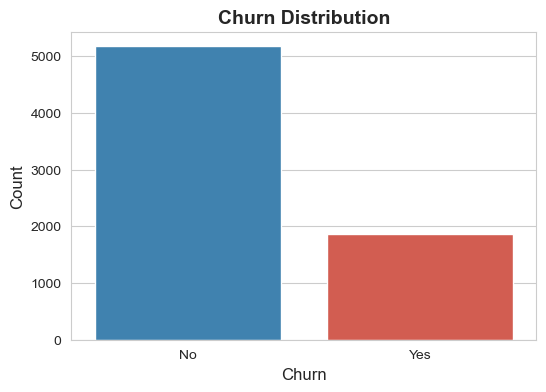

In [4]:
# VIZ

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern style
sns.set_style("whitegrid")
sns.set_palette("pastel")

# 1. Churn Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette=['#2E86C1', '#E74C3C'])
plt.title('Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [5]:
# 1.4. Normalize or standardize numerical features
# df.columns

# Standardization (z-score method) → If using models like Logistic Regression, SVM, or ANN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Normalization (min-max scaling) → If using distance-based models like KNN or Neural Networks
'''from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])'''

"from sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\ndf[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])"

In [6]:
# 1.5. Encode categorical variables (OHE, label encoding) 
'''
Potential Data Leakage Concerns:
-If encoding methods like one-hot encoding (OHE) or label encoding are used, they should be done before splitting, as they don’t rely on the dataset distribution.
-If target encoding or mean encoding (which depend on target labels) is used, it must be done after splitting to avoid data leakage.
'''
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding (for Binary/Ordinal Categories)
label_enc_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()

for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])  # 0 or 1 encoding for binary categories

# One-Hot Encoding (for Nominal Categories)
ohe_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=ohe_cols, drop_first=True).astype(int) # drop_first=True to avoid multicollinearity

# Final Processed DataFrame
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1,0,1,-1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,-1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [34]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [7]:
''' CODE FOR ENCODING AFTER TRAIN-TEST SPLIT
# Encode categorical variables with multiple levels using one-hot encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
categorical_indices=[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16]
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_indices )], remainder='passthrough')

# Fit and transform on training data
X_train = ct.fit_transform(X_train)

# Transform the test data based on the training data encoding
X_test = ct.transform(X_test)

# Encoding target variable
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the target variable (Churn)
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
'''

" CODE FOR ENCODING AFTER TRAIN-TEST SPLIT\n# Encode categorical variables with multiple levels using one-hot encoding\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\ncategorical_indices=[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16]\nct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_indices )], remainder='passthrough')\n\n# Fit and transform on training data\nX_train = ct.fit_transform(X_train)\n\n# Transform the test data based on the training data encoding\nX_test = ct.transform(X_test)\n\n# Encoding target variable\nfrom sklearn.preprocessing import LabelEncoder\n\n# Create an instance of LabelEncoder\nle = LabelEncoder()\n\n# Apply LabelEncoder to the target variable (Churn)\ny_train = le.fit_transform(y_train)\ny_test = le.transform(y_test)\n"

In [8]:
# 1.6. Feature selection and dimensionality reduction (if needed, e.g., PCA)

# 1.7. Balance the dataset (oversampling/undersampling if necessary)
#df['Churn'].value_counts()
#The minority class (churn) is significantly underrepresented (it’s roughly 1/3 of the total)
'''
# SMOTE is typically preferred over simple oversampling because it generates synthetic examples, which helps avoid overfitting to duplicate data.
# Undersampling is an option if you want a quick fix but might result in losing useful data.
# Class weights should be used if you don’t want to alter the data but still want to improve model sensitivity to the minority class.

#option 1: Random Oversampling (Increase Minority Class)
from sklearn.utils import resample
df_churn = df[df['Churn'] == 1] # Separate the majority and minority class
df_no_churn = df[df['Churn'] == 0] # Separate the majority and minority class
df_churn_oversampled = resample(df_churn, replace=True, n_samples=len(df_no_churn), random_state=42) # Oversample the minority class (churn)
df_balanced = pd.concat([df_churn_oversampled, df_no_churn]) # Combine the oversampled minority class with the majority class
print(df_balanced['Churn'].value_counts()) # Check the new class distribution

# option 2: SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE
X = df.drop('Churn', axis=1) # Separate features and target
y = df['Churn'] # Separate features and target
smote = SMOTE(random_state=42) # Apply SMOTE to balance the dataset
X_smote, y_smote = smote.fit_resample(X, y) # Apply SMOTE to balance the dataset
print(pd.Series(y_smote).value_counts()) # Check the new class distribution

# option 3: Random Undersampling (Reduce Majority Class)
df_no_churn_undersampled = resample(df_no_churn, replace=False, n_samples=len(df_churn), random_state=42) # Undersample the majority class (non-churn)
df_balanced_undersample = pd.concat([df_churn, df_no_churn_undersampled]) # Combine the undersampled majority class with the minority class
print(df_balanced_undersample['Churn'].value_counts()) # Check the new class distribution

# option 4: Using Class Weightse, when using Logistic Regression or Random Forest, you can use the class_weight='balanced' parameter
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42) # Define model with class weights
model.fit(X_train, y_train) # Train the model on your data
'''

"\n# SMOTE is typically preferred over simple oversampling because it generates synthetic examples, which helps avoid overfitting to duplicate data.\n# Undersampling is an option if you want a quick fix but might result in losing useful data.\n# Class weights should be used if you don’t want to alter the data but still want to improve model sensitivity to the minority class.\n\n#option 1: Random Oversampling (Increase Minority Class)\nfrom sklearn.utils import resample\ndf_churn = df[df['Churn'] == 1] # Separate the majority and minority class\ndf_no_churn = df[df['Churn'] == 0] # Separate the majority and minority class\ndf_churn_oversampled = resample(df_churn, replace=True, n_samples=len(df_no_churn), random_state=42) # Oversample the minority class (churn)\ndf_balanced = pd.concat([df_churn_oversampled, df_no_churn]) # Combine the oversampled minority class with the majority class\nprint(df_balanced['Churn'].value_counts()) # Check the new class distribution\n\n# option 2: SMOTE (S

In [9]:
#X = df.iloc[:, 1:-1].values
#y = df.iloc[:, -1].values
#y = y.reshape(len(y),1)
X = df.drop(columns=['Churn']).values  # Features (all columns except 'Churn')
y = df['Churn'].values  # Target variable (Churn)

# 1.8. Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
X[0]

array([ 0,  0,  1,  0, -1,  0,  1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0])

In [11]:
#
#
#
# MODEL EVALUATION for comparing all models in end
def get_model_metrics(X_test, y_test, y_pred, model, model_name):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()

    # Classification Report (Precision, Recall, F1-score, Support)
    report = classification_report(y_test, y_pred, output_dict=True)

    # ROC-AUC Score
    # Probabilities for positive class
    if hasattr(model, "predict_proba"):  # For models like Logistic Regression, Random Forest, etc.
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:  # For ANN or other models without predict_proba
        roc_auc = roc_auc_score(y_test, model.predict(X_test))

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)

    # Compile all metrics into a dictionary
    metrics_dict = {
        "Model": [model_name],  # Add the model name
        "Confusion Matrix: TN-FP": [TN-FP],
        "Confusion Matrix: FN-FP": [FN-FP],
        "Confusion Matrix: TN-TP": [TN-TP],
        "Confusion Matrix: FN-TP": [FN-TP],
        "Classification Report: 0-precision": [report['0']['precision']],
        "Classification Report: 1-precision": [report['1']['precision']],
        "Classification Report: 0-recall": [report['0']['recall']],
        "Classification Report: 1-recall": [report['1']['recall']],
        "Classification Report: 0-f1-score": [report['0']['f1-score']],
        "Classification Report: 1-f1-score": [report['1']['f1-score']],
        "Classification Report: 0-support": [report['0']['support']],
        "Classification Report: 1-support": [report['1']['support']],
        "Classification Report: accuracy-f1-score": [report['accuracy']],
        "Classification Report: accuracy-support": [report['macro avg']['support']],
        "Classification Report: macro avg-precision": [report['macro avg']['precision']],
        "Classification Report: macro avg-recall": [report['macro avg']['recall']],
        "Classification Report: macro avg-f1-score": [report['macro avg']['f1-score']],
        "Classification Report: macro avg-support": [report['macro avg']['support']],
        "Classification Report: weighted avg-precision": [report['weighted avg']['precision']],
        "Classification Report: weighted avg-recall": [report['weighted avg']['recall']],
        "Classification Report: weighted avg-f1-score": [report['weighted avg']['f1-score']],
        "Classification Report: weighted avg-support": [report['weighted avg']['support']],
        "ROC-AUC Score": [roc_auc],
        "Accuracy": [accuracy]
    }

    # Convert the dictionary to a Pandas DataFrame
    metrics_df = pd.DataFrame(metrics_dict)
    
    return metrics_df
#
#
#

In [12]:
#
#
#
# MODEL EVALUATION for comparing all models in end
def get_model_metrics_viz(X_test, y_test, y_pred, model, model_name):
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
    
    ### Evaluate the model's performance 
    
    # Confusion Matrix to see true positives, false positives, etc.
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Churn: 0 (TN)", "Actual Churn: 1 (FN)"], columns=["Pred Churn: 0 (FP)", "Pred Churn: 1 (TP)"])
    print("Confusion Matrix:\n", conf_matrix_df)
    
    # Generate a classification report (precision, recall, F1-score, etc.)
    # For Precision, Recall and F1-score, Closer to 1 means the model is performing better
    # Precision = true positive predictions / predicted positive
    # Recall = true positive predictions / actual positive 
    # F1-Score is the harmonic mean of precision and recall = 2 * (P*R)/(P+R)
    # Support is the number of true instances of each class in the dataset
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:\n", report)
    
    # ROC-AUC Score for evaluating the model's ability to distinguish between classes
    # Probabilities for positive class
    if hasattr(model, "predict_proba"):  # For models like Logistic Regression, Random Forest, etc.
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:  # For ANN or other models without predict_proba
        roc_auc = roc_auc_score(y_test, model.predict(X_test))
    print(f"\nROC-AUC Score: {roc_auc}")
    
    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy}")
    return
#
#
#

In [13]:
# Logistic regression
# Apply Logistic Regression with Class Balancing
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
model_logistic = LogisticRegression(class_weight='balanced', random_state=42)
model_logistic.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_logistic.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_logistic = get_model_metrics(X_test, y_test, y_pred, model_logistic, model_name='Logistic')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_logistic, model_name='Logistic')
joblib.dump(model_logistic, 'model/model_logistic.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 752                 283
Actual Churn: 1 (FN)                  78                 296

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409


ROC-AUC Score: 0.8397349453615438

Accuracy: 0.7437899219304471


['model/model_logistic.pkl']

In [14]:
# reverse X = df.drop(columns=['Churn']).values  
#X_df = pd.DataFrame(X, columns=df.drop(columns=['Churn']).columns)


# INTERPRETABILITY

# Get coefficients
coefficients = model_logistic.coef_[0]  # Logistic Regression returns an array, so extract first element

# Compute odds ratios
odds_ratios = np.exp(coefficients)

# Create a DataFrame for better readability
feature_names = df.drop(columns=['Churn']).columns
odds_ratios_df = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios})
print(odds_ratios_df.sort_values(by='Odds Ratio', ascending=False))  # Sort by impact

# EXAMPLE
#customers on a two-year contract have an 81.6% lower odds of churning compared to the reference group (1 - 0.184 = 81.6%)
#Customers on a one-year contract have a 60.6% lower odds of churning compared to the reference group (1 - 0.394 = 60.6%).

                                  Feature  Odds Ratio
11            InternetService_Fiber optic    2.200637
28         PaymentMethod_Electronic check    1.550947
6                        PaperlessBilling    1.412090
9          MultipleLines_No phone service    1.260685
24                    StreamingMovies_Yes    1.248689
7                          MonthlyCharges    1.220790
10                      MultipleLines_Yes    1.216208
22                        StreamingTV_Yes    1.210718
8                            TotalCharges    1.196945
1                           SeniorCitizen    1.128973
29             PaymentMethod_Mailed check    1.090996
0                                  gender    1.024168
27  PaymentMethod_Credit card (automatic)    0.994966
2                                 Partner    0.979518
18                   DeviceProtection_Yes    0.935727
12                     InternetService_No    0.897193
19        TechSupport_No internet service    0.897193
23    StreamingMovies_No int

In [15]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN model
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_knn.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_knn = get_model_metrics(X_test, y_test, y_pred, model_knn, model_name='K-NN')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_knn, model_name='K-NN')
joblib.dump(model_knn, 'model/model_knn.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 869                 166
Actual Churn: 1 (FN)                 176                 198

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1035
           1       0.54      0.53      0.54       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.69      1409
weighted avg       0.76      0.76      0.76      1409


ROC-AUC Score: 0.7744955953395851

Accuracy: 0.7572746628814763


['model/model_knn.pkl']

In [16]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Support Vector Machines (SVM)
from sklearn.svm import SVC

# Initialize and train SVM model
model_svm = SVC(class_weight='balanced', random_state=42)
model_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_svm.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_svm = get_model_metrics(X_test, y_test, y_pred, model_svm, model_name='SVM')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_svm, model_name='SVM')
joblib.dump(model_svm, 'model/model_svm.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 767                 268
Actual Churn: 1 (FN)                  84                 290

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


ROC-AUC Score: 0.7582319357255418

Accuracy: 0.7501774308019872


['model/model_svm.pkl']

In [17]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Kernel Support Vector Machines (Kernel SVM)

from sklearn.svm import SVC

# Initialize and train Kernel SVM model
model_kernel_svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
model_kernel_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_kernel_svm.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_ksvm = get_model_metrics(X_test, y_test, y_pred, model_kernel_svm, model_name='Kernel SVM')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_kernel_svm, model_name='Kernel SVM')
joblib.dump(model_kernel_svm, 'model/model_kernel_svm.pkl')


Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 767                 268
Actual Churn: 1 (FN)                  84                 290

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


ROC-AUC Score: 0.7582319357255418

Accuracy: 0.7501774308019872


['model/model_kernel_svm.pkl']

In [18]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Naive Bayes

from sklearn.naive_bayes import GaussianNB

# Initialize and train Naive Bayes model
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_nb.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_nb = get_model_metrics(X_test, y_test, y_pred, model_nb, model_name='Naive Bayes')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_nb, model_name='Naive Bayes')
joblib.dump(model_nb, 'model/model_nb.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 590                 445
Actual Churn: 1 (FN)                  48                 326

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.57      0.71      1035
           1       0.42      0.87      0.57       374

    accuracy                           0.65      1409
   macro avg       0.67      0.72      0.64      1409
weighted avg       0.79      0.65      0.67      1409


ROC-AUC Score: 0.8081893099795914

Accuracy: 0.6501064584811923


['model/model_nb.pkl']

In [19]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Initialize and train Decision Tree model
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_dt.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_dt = get_model_metrics(X_test, y_test, y_pred, model_dt, model_name='Decision Trees')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_dt, model_name='Decision Trees')
joblib.dump(model_dt, 'model/model_dt.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 803                 232
Actual Churn: 1 (FN)                 157                 217

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1035
           1       0.48      0.58      0.53       374

    accuracy                           0.72      1409
   macro avg       0.66      0.68      0.67      1409
weighted avg       0.74      0.72      0.73      1409


ROC-AUC Score: 0.681734222015552

Accuracy: 0.7239176721078779


['model/model_dt.pkl']

In [20]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classification 
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest Classifier model
model_random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model_random_forest.fit(X_train, y_train)

# EVALUATION FOR COMPARISON
eval_random_forest = get_model_metrics(X_test, y_test, y_pred, model_random_forest, model_name='Random Forest')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_random_forest, model_name='Random Forest')
joblib.dump(model_random_forest, 'model/model_random_forest.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 803                 232
Actual Churn: 1 (FN)                 157                 217

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1035
           1       0.48      0.58      0.53       374

    accuracy                           0.72      1409
   macro avg       0.66      0.68      0.67      1409
weighted avg       0.74      0.72      0.73      1409


ROC-AUC Score: 0.8043258673693457

Accuracy: 0.7239176721078779


['model/model_random_forest.pkl']

In [21]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# !pip install xgboost
import xgboost as xgb

# Initialize the XGBoost classifier
model_xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
model_xgboost.fit(X_train, y_train)

# Make predictions
y_pred = model_xgboost.predict(X_test)

# EVALUATION FOR COMPARISON
eval_xgboost = get_model_metrics(X_test, y_test, y_pred, model_xgboost, model_name='XGBoost')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_xgboost, model_name='XGBoost')
joblib.dump(model_xgboost, 'model/model_xgboost.pkl')

Confusion Matrix:
                       Pred Churn: 0 (FP)  Pred Churn: 1 (TP)
Actual Churn: 0 (TN)                 892                 143
Actual Churn: 1 (FN)                 179                 195

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      1035
           1       0.58      0.52      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409


ROC-AUC Score: 0.8012658554858043

Accuracy: 0.7714691270404542


/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:24:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['model/model_xgboost.pkl']

In [22]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ARTIFICIAL NEURAL NETWORKS
import tensorflow as tf

# Disable GPU (Optional)
tf.config.set_visible_devices([], 'GPU')  # Disable default GPU setting

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is now enabled with Metal API")
    

# Define the ANN model
model_ann_10 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Another hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ann_10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_ann_10.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = (model_ann_10.predict(X_test) > 0.5).astype(int)

# EVALUATION FOR COMPARISON
eval_ann_10 = get_model_metrics(X_test, y_test, y_pred, model_ann_10, model_name='ANN (10 Epochs)')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_ann_10, model_name='ANN (10 Epochs)')
model_ann_10.save('model/model_ann_10.keras')

GPU is now enabled with Metal API
Epoch 1/10


/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7060 - loss: 0.5433 - val_accuracy: 0.7956 - val_loss: 0.4269
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.7950 - loss: 0.4271 - val_accuracy: 0.7913 - val_loss: 0.4260
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.8017 - loss: 0.4237 - val_accuracy: 0.7949 - val_loss: 0.4199
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.8060 - loss: 0.4162 - val_accuracy: 0.7949 - val_loss: 0.4217
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.8069 - loss: 0.4037 - val_accuracy: 0.7984 - val_loss: 0.4202
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.8122 - loss: 0.4094 - val_accuracy: 0.7970 - val_loss: 0.4259
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.8135 - loss: 0.3909 - val_accuracy: 0.7885 - val_loss: 0.4243
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8029 - loss: 0.4106 - val_accuracy:

In [23]:
# MORE EPOCHS BETTER RESULT? OVERFITTING?

# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ARTIFICIAL NEURAL NETWORKS ----- 25 EPOCHS
# import tensorflow as tf

# Define the ANN model
model_ann_25 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Another hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ann_25.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_ann_25.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = (model_ann_25.predict(X_test) > 0.5).astype(int)

# EVALUATION FOR COMPARISON
eval_ann_25 = get_model_metrics(X_test, y_test, y_pred, model_ann_25, model_name='ANN (25 Epochs)')

# EVALUATION FOR VISUALIZING
get_model_metrics_viz(X_test, y_test, y_pred, model_ann_25, model_name='ANN (25 Epochs)')
model_ann_25.save('model/model_ann_25.keras')
joblib.dump(model_ann_25, 'model/model_ann_25.pkl')

Epoch 1/25


/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7196 - loss: 0.5238 - val_accuracy: 0.7949 - val_loss: 0.4311
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7956 - loss: 0.4192 - val_accuracy: 0.7928 - val_loss: 0.4229
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7969 - loss: 0.4201 - val_accuracy: 0.7871 - val_loss: 0.4220
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.8071 - loss: 0.4018 - val_accuracy: 0.7913 - val_loss: 0.4211
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.7954 - loss: 0.4214 - val_accuracy: 0.7913 - val_loss: 0.4228
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7974 - loss: 0.4075 - val_accuracy: 0.7935 - val_loss: 0.4212
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.8063 - loss: 0.4029 - val_accuracy: 0.7892 - val_loss: 0.4218
Epoch 8/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.8091 - loss: 0.4004 - val_accuracy:

['model/model_ann_25.pkl']

In [24]:
eval_final = pd.concat([eval_logistic, eval_knn, eval_svm, eval_ksvm, eval_nb, eval_dt, eval_random_forest, eval_xgboost, eval_ann_10, eval_ann_25], ignore_index=True)
eval_final

,Model,Confusion Matrix: TN-FP,Confusion Matrix: FN-FP,Confusion Matrix: TN-TP,Confusion Matrix: FN-TP,Classification Report: 0-precision,Classification Report: 1-precision,Classification Report: 0-recall,Classification Report: 1-recall,Classification Report: 0-f1-score,Classification Report: 1-f1-score,Classification Report: 0-support,Classification Report: 1-support,Classification Report: accuracy-f1-score,Classification Report: accuracy-support,Classification Report: macro avg-precision,Classification Report: macro avg-recall,Classification Report: macro avg-f1-score,Classification Report: macro avg-support,Classification Report: weighted avg-precision,Classification Report: weighted avg-recall,Classification Report: weighted avg-f1-score,Classification Report: weighted avg-support,ROC-AUC Score,Accuracy
0,Logistic,469,-205,456,-218,0.906024,0.511226,0.726570,0.791444,0.806434,0.621196,1035.0,374.0,0.743790,1409.0,0.708625,0.759007,0.713815,1409.0,0.801230,0.743790,0.757265,1409.0,0.839735,0.743790
1,K-NN,703,10,671,-22,0.831579,0.543956,0.839614,0.529412,0.835577,0.536585,1035.0,374.0,0.757275,1409.0,0.687767,0.684513,0.686081,1409.0,0.755233,0.757275,0.756214,1409.0,0.774496,0.757275
2,SVM,499,-184,477,-206,0.901293,0.519713,0.741063,0.775401,0.813362,0.622318,1035.0,374.0,0.750177,1409.0,0.710503,0.758232,0.717840,1409.0,0.800008,0.750177,0.762652,1409.0,0.758232,0.750177
3,Kernel SVM,499,-184,477,-206,0.901293,0.519713,0.741063,0.775401,0.813362,0.622318,1035.0,374.0,0.750177,1409.0,0.710503,0.758232,0.717840,1409.0,0.800008,0.750177,0.762652,1409.0,0.758232,0.750177
4,Naive Bayes,145,-397,264,-278,0.924765,0.422827,0.570048,0.871658,0.705320,0.569432,1035.0,374.0,0.650106,1409.0,0.673796,0.720853,0.637376,1409.0,0.791532,0.650106,0.669250,1409.0,0.808189,0.650106
5,Decision Trees,571,-75,586,-60,0.836458,0.483296,0.775845,0.580214,0.805013,0.527339,1035.0,374.0,0.723918,1409.0,0.659877,0.678030,0.666176,1409.0,0.742716,0.723918,0.731308,1409.0,0.681734,0.723918
6,Random Forest,571,-75,586,-60,0.836458,0.483296,0.775845,0.580214,0.805013,0.527339,1035.0,374.0,0.723918,1409.0,0.659877,0.678030,0.666176,1409.0,0.742716,0.723918,0.731308,1409.0,0.804326,0.723918
7,XGBoost,749,36,697,-16,0.832866,0.576923,0.861836,0.521390,0.847104,0.547753,1035.0,374.0,0.771469,1409.0,0.704895,0.691613,0.697428,1409.0,0.764930,0.771469,0.767645,1409.0,0.801266,0.771469
8,ANN (10 Epochs),757,20,681,-56,0.849289,0.607345,0.865700,0.574866,0.857416,0.590659,1035.0,374.0,0.788502,1409.0,0.728317,0.720283,0.724038,1409.0,0.785068,0.788502,0.786609,1409.0,0.837663,0.788502
9,ANN (25 Epochs),765,34,695,-36,0.841908,0.602941,0.869565,0.548128,0.855513,0.574230,1035.0,374.0,0.784244,1409.0,0.722425,0.708847,0.714871,1409.0,0.778478,0.784244,0.780850,1409.0,0.829215,0.784244


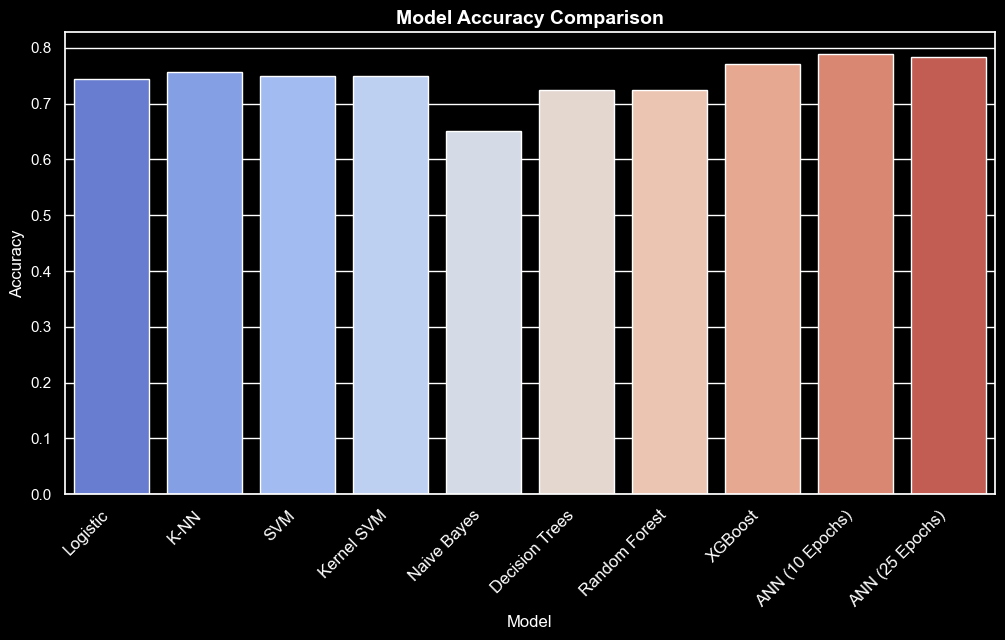

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set dark theme
sns.set_theme(style="darkgrid")
plt.style.use("dark_background")

# 1. Bar Chart: Model Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=eval_final, palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

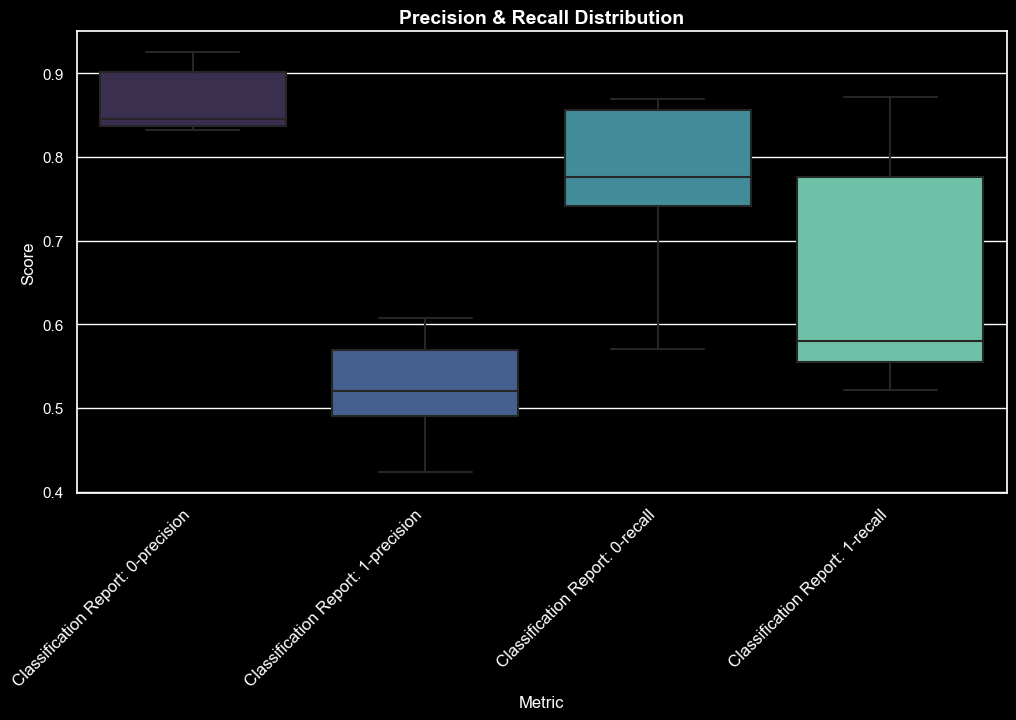

In [26]:
# 2. Box Plot: Precision & Recall Distribution
plt.figure(figsize=(12, 6))
df_melted = eval_final.melt(id_vars=["Model"], value_vars=["Classification Report: 0-precision", "Classification Report: 1-precision", "Classification Report: 0-recall", "Classification Report: 1-recall"], var_name="Metric", value_name="Score")
sns.boxplot(x="Metric", y="Score", data=df_melted, palette="mako")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Precision & Recall Distribution", fontsize=14, fontweight="bold")
plt.show()

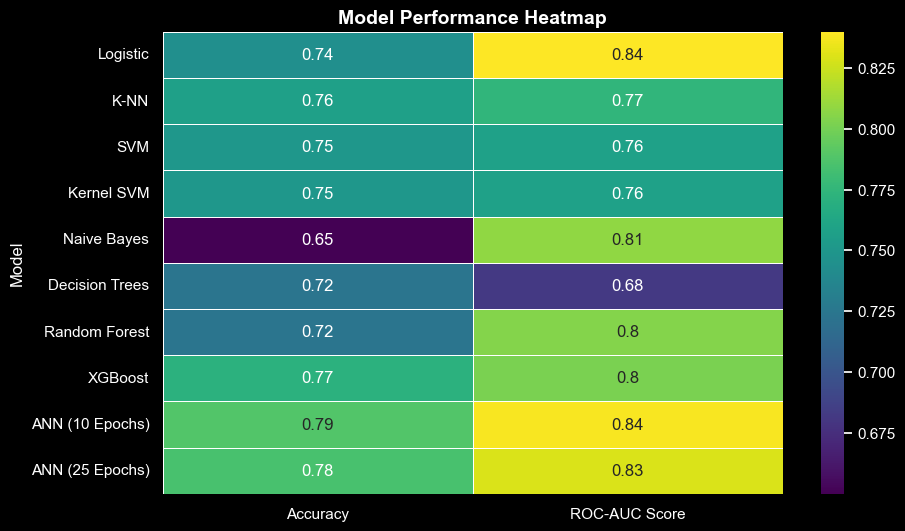

In [27]:
# 3. Heatmap: Accuracy & ROC-AUC
plt.figure(figsize=(10, 6))
sns.heatmap(eval_final.set_index("Model")[['Accuracy', 'ROC-AUC Score']], annot=True, cmap="viridis", linewidths=0.5)
plt.title("Model Performance Heatmap", fontsize=14, fontweight="bold")
plt.show()

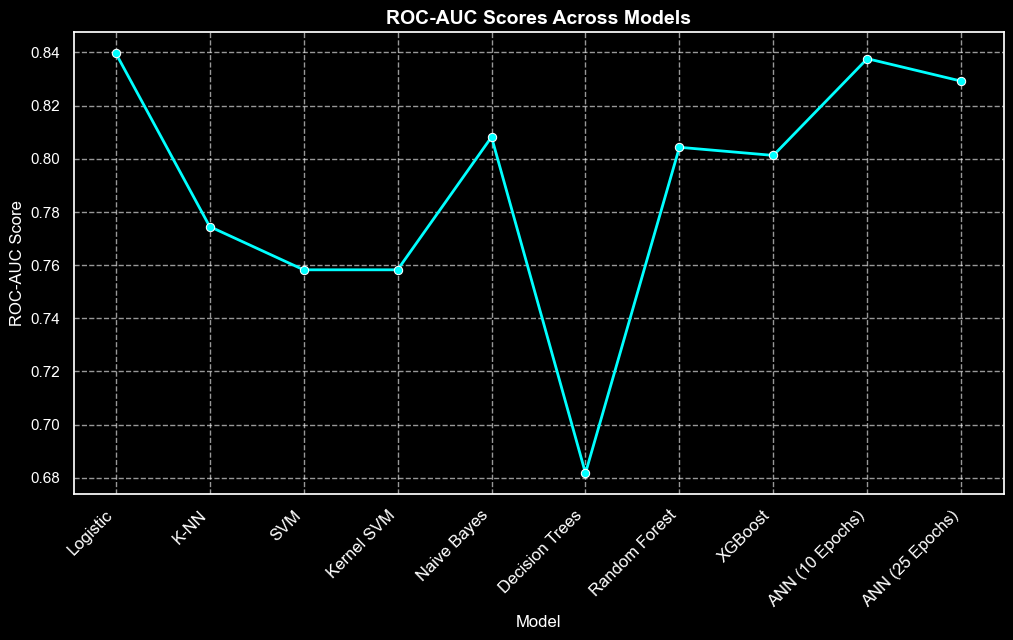

In [28]:
# 4. Line Chart: ROC-AUC Trend
plt.figure(figsize=(12, 6))
sns.lineplot(x="Model", y="ROC-AUC Score", data=eval_final, marker="o", color="cyan", linewidth=2)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("ROC-AUC Scores Across Models", fontsize=14, fontweight="bold")
plt.ylabel("ROC-AUC Score")
plt.xlabel("Model")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [29]:
# Tune Hyperparameters (optional, using GridSearchCV or RandomizedSearchCV)


In [30]:
# Model Deployment
# Save the Model for future use (e.g., joblib or pickle)
# Deploy the Model to make predictions on new unseen data

In [31]:
# End!